In [1]:
# Compare Algorithms
import pandas
import numpy as np
import matplotlib.pyplot as plt

#import method releated to evaluation
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, StratifiedShuffleSplit, ShuffleSplit, cross_val_score, GridSearchCV

#transformers
from sklearn.preprocessing import StandardScaler

#metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

#export the models from the sklearn library
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
%matplotlib inline


# Load the breast cancer dataset

In [2]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)
df=pandas.DataFrame(X, y)
df.tail()
df.shape

seed =100
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=seed)

# Creating a pipeline
Lets start by standadizing the breast cancer dataset. Lets also assume we want to compress the features into 2 principal components. For this we will use principal component analysis as a feature extractor method to dimensionality reduction.
We can include each of these steps in a pipeline which will see next. 
<img src="pipeline.png", width=500>
The pipeline object takes a list of tuples as input, where the first vaule in each tuple is an arbitrary identifier string that we can use to access the individual elements in the pipeline. The second element in every tuple is a scikit-learn transformer or estimator. 


In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

pipeline = make_pipeline(StandardScaler(), # normilising values
                        PCA(n_components=2), # extracting features
                        LogisticRegression(random_state=1)) # specify a basic classifier

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('Test Accuracy: %.3f' % pipeline.score(X_test, y_test))


Test Accuracy: 0.974


# Exercise
Repeat the code above for a different classifier. For instance you could use SVC or MLPClassifier. Note a list of classifiers were provided in evaluation part1 e.g. 
LogisticRegression(), LinearDiscriminantAnalysis(), KNeighborsClassifier(), DecisionTreeClassifier(), GaussianNB(), SVC(kernel='rbf', gamma=0.7, C=1.0), MLPClassifier()

# Understanding underfitting and overfitting problems
we will see how to address these model issues using validation curves. For this we will use scikit-learn's learning curve function to evaulate the models. 

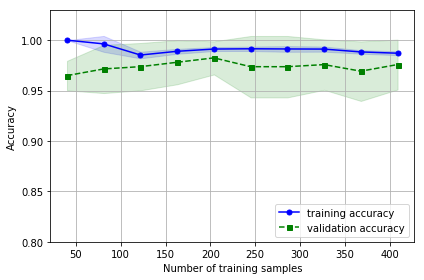

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe = make_pipeline(StandardScaler(),
                       LogisticRegression(penalty='l2', random_state=1))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()

The train_sizes parameter in the learning_curve function, we can control the absolute or relative number of training samples that are used to generate the learning curve. Here we set training_sizes = np.linspace(0.1, 1.0, 10) to use 10 evenly spaced relative intervals for the training set sizes. 
By default the learning_curve function uses stratified k-fold cross validationto calculate the cross-validation accuracy. We set k =10 via the cv parameter. 
the mathplotlib simply plots on the x axis for increasing values of the training set size the accuracy on the y-axis. 
Note the use of the standard deviation to colour the area above and below the mean accuracy values of the validation accuracy. This is done using the fill_between function to indicate the variance estimation. 

From the plot we can conclude that our model is doing good; however there might be some evidence to suggest a slight overfitting to training data; due to the visible (though small ) gap with the validation accuracy. 


# Exercise
Once again you can try the above code for different classifiers. However make sure relevant parameters are set with each. For example a basic ANN can be called with MLPClassifier(). You can read up on the different hyper parameters and how to set them here http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html


# Evaluation Metrics
To study the different metrics provided in sklearn; lets first create grid search cross validation with a basic MLPClassifier.
You can study the param_grid to understand the different hyper parameter values that we plan to explore. 

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score

#pipe.fit(X_train, y_train)
#y_pred = pipe.predict(X_test)

param_grid = [
        {
            'activation' : ['identity', 'logistic', 'relu'], 
            'solver' : ['lbfgs', 'adam'],
            'hidden_layer_sizes': [(10,),(30,)] # a single hidden layer
        }
       ]

gs = GridSearchCV(MLPClassifier(), param_grid, cv=10, scoring='accuracy')
gs.fit(X_train,y_train)
y_pred = gs.predict(X_test)

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))


Test accuracy: 0.947


## Precision and Recall Scores
Scoring metrics are all implmented in scikit-learn and can be imported from the sklearn.metrics module. 
For multiclass metrics these need to be used with macro or micro options. 


In [6]:
y_pred = clf.predict(X_test)
print(y_pred, y_test)
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

[1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 1 0
 1 0 1 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1
 0 0 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1
 0 0 0] [1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0
 1 0 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1
 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1
 0 0 0]
Precision: 0.958
Recall: 0.958
F1: 0.958


# Breast Cancer - Generating ROC Curves on a Binary Classification Task
We will use the load function (load_breast_cancer) that is already provided with scikitLearn for this dataset.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=seed)

# k-NN model creates confidences based on the mean of the k nearest neighbors
model1 = KNeighborsClassifier(n_neighbors=5, weights='distance')
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print("Training set score: %f" % model1.score(X_train, y_train))
print("Test set score: %f" % model1.score(X_test, y_test))

model2 = KNeighborsClassifier(n_neighbors=21, weights='distance')
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print("Training set score: %f" % model2.score(X_train, y_train))
print("Test set score: %f" % model2.score(X_test, y_test))

#Neural nets creates confidences based on the output activation
model3=MLPClassifier(hidden_layer_sizes=(300,), max_iter=20,)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
print("Training set score: %f" % model3.score(X_train, y_train))
print("Test set score: %f" % model3.score(X_test, y_test))

Training set score: 1.000000
Test set score: 0.936768
Training set score: 1.000000
Test set score: 0.920375
Training set score: 0.725352
Test set score: 0.688525


# What information do we need to generate the ROC curve?

## Receiver Operating Characteristic (ROC)



ROC curves typically feature true positive rate on the Y axis, and false
positive rate on the X axis. This means that the top left corner of the plot is
the "ideal" point - a false positive rate of zero, and a true positive rate of
one. This is not very realistic, but it does mean that a larger area under the
curve (AUC) is usually better.

The "steepness" of ROC curves is also important, since it is ideal to maximize
the true positive rate while minimizing the false positive rate.


Example of Receiver Operating Characteristic (ROC) metric to evaluate
classifier output quality appears next.
Primarily we need to have the false positive rate and true positive rate at hand. 
Additionally the plot requires different levels of thresholds at which it will generate the tpr and fpr; that then get plotted. 
You can see from the accuracy results and the ROC curve that the neural net (MLP) struggles to acheive good performance compared to kNN on this dataset.

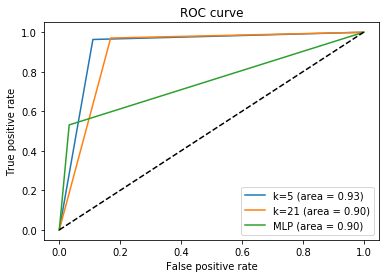

In [8]:
fpr1, tpr1, threshold1 = roc_curve(y_test, y_pred1) 
fpr2, tpr2, threshold2 = roc_curve(y_test, y_pred2) 
fpr3, tpr3, threshold3 = roc_curve(y_test, y_pred3) 
# This is the AUC
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)
#auc = np.trapz(tpr1,fpr1)

# This is the ROC curve
plt.plot(fpr1,tpr1, label='k=5 (area = %0.2f)' % (auc1))
plt.plot(fpr2,tpr2, label='k=21 (area = %0.2f)' % (auc2))
plt.plot(fpr3,tpr3, label='MLP (area = %0.2f)' % (auc2))
plt.plot([0, 1], [0, 1], 'k--') # diagonal

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show() 

# Additional ROC curves using all the models on the breast cancer dataset

[0.         0.09433962 1.        ] [0.         0.97777778 1.        ] [2 1 0]
[0.        0.0754717 1.       ] [0. 1. 1.] [2 1 0]
[0.         0.13207547 1.        ] [0.         0.95555556 1.        ] [2 1 0]
[0.         0.09433962 1.        ] [0.         0.93333333 1.        ] [2 1 0]
[0.         0.11320755 1.        ] [0.         0.97777778 1.        ] [2 1 0]
[0. 1.] [0. 1.] [2 1]
[0.         0.94339623 1.        ] [0. 1. 1.] [2 1 0]


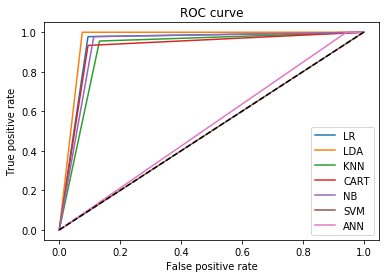

In [9]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel='rbf', gamma=0.7, C=1.0)))
models.append(('ANN', MLPClassifier()))

split = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=seed)
split.get_n_splits(X, y)

for train_index, test_index in split.split(X, y):
    #print('TRAIN:', train_index)
    #print('TEST:', test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

results = []
names = []

##iterate through each model
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    fpr, tpr, threshold = roc_curve(y_test, y_pred) 
    #auc = auc(fpr, tpr)
    plt.plot(fpr,tpr, label=name)# '%s (area = %0.2f)' % (name, auc))
    print(fpr, tpr, threshold)
    results.append([fpr, tpr, threshold])
    names.append(name)

results = np.asarray(results)
plt.plot([0, 1], [0, 1], 'k--') # diagonal
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show() 
#print('std', results.std())
#msg = "%s: %f (%f)" % (name, results.mean(), results.std())
#print(msg)

# Exercise 
Which category of classifiers do you think are performing best on this dataset?

Try the above comparison with a stratified 10 fold cross validation.

# Iris Dataset for scoring for multiclass metrics
## Recall, Precision and F1 

Options for multiclass situations other than with 'accuracy' commonly uses the macro and micro versions of recall, precision and F1 measures. Macro aggregations treat all classes as equally impportant. However this can lead to misleading resulst for instance if you have a unbalanced dataset where one class few instances that are all correctly classifier yet another class has many instances but are incorrectly classified. Here the Micro aggregation version is better suited at it will capture a less optimistic view of the algorithm performance. 
Note that when we use recall and precision related metrics on multi-class problems the metric calculation will adopt a one-versus-all view of the classifier to count the TPs and FPs.

In [10]:
from sklearn.datasets import load_iris

scoring = 'recall_macro'
scoring_list = ['f1_macro', 'f1_micro', 'f1_weighted', 'precision_macro', 'precision_micro', 'precision_weighted', 
                'recall_macro', 'recall_micro', 'recall_weighted']
model = KNeighborsClassifier()
#lets load the Iris dataset which is part of the sklearn library


iris = load_iris()
X, y = iris.data, iris.target
class_names = iris.target_names

kfold = StratifiedShuffleSplit(n_splits=10, random_state=seed, test_size=.4)
for scoring in scoring_list:
    print(scoring)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    print(cv_results.mean())

f1_macro
0.9598573143365214
f1_micro
0.96
f1_weighted
0.9598573143365213
precision_macro
0.9630108869010471
precision_micro
0.96
precision_weighted
0.9630108869010471
recall_macro
0.96
recall_micro
0.96
recall_weighted
0.96


## Exercise
Do you understand why we need macro and micro versions of recall and precision scoring with multi-class datasets?